In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
survey_all = pd.read_csv('./../../../Swedish National Travel Survey (2011-2016)/survey_trips.csv')

In [60]:
# segments per trip

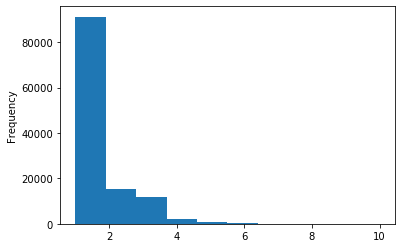

In [61]:
survey_all[['sub_id', 'trip_id', 'trip_main_id', 'trip_seg_id']].groupby(['sub_id', 'trip_id', 'trip_main_id']).size().plot.hist()

In [62]:
survey_all[['sub_id', 'trip_id', 'trip_main_id', 'trip_seg_id']][survey_all['trip_seg_id'] == 1].groupby(['sub_id', 'trip_id']).size().describe()

count    73379.000000
mean         1.654424
std          0.939566
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         26.000000
dtype: float64

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


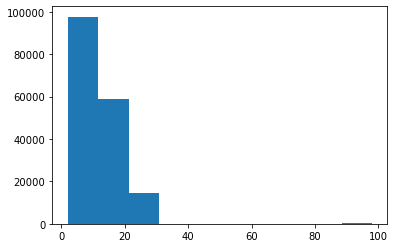

In [63]:
_ = plt.hist(survey_all['purpose'])

0      2
1      3
2      4
3      5
4      6
5      7
6      8
7      9
8     10
9     11
10    12
11    13
12    14
13    15
14    16
15    17
16    18
17    19
18    20
19    21
20    22
21    23
22    24
23    25
24    33
25    34
26    35
27    36
28    37
29    55
30    80
31    81
32    82
33    85
34    86
35    87
36    97
37    98
Name: value, dtype: int64

In [101]:
survey = survey_all[['sub_id', 'commute_mode', 'commute_distance', 'commute_time', 'date', 'trip_id', 'trip_main_id', 'origin_main_time', 'desti_main_time', 'origin_time', 'desti_time', 'distance', 'tt', 'mode', 'purpose', 'origin_t']]




In [102]:
trips = survey.groupby(['sub_id', 'trip_id', 'trip_main_id'], as_index=False).first()

In [121]:
trips['origin_main_time'].astype(str).unique()

array(['1815.0', '830.0', '1130.0', ..., '1259.0', '939.0', '608.0'],
      dtype=object)

In [163]:
def str_timestamp_to_datetime(time_column):
    def fn(row):
        d = pd.to_datetime(row['date'])
        timestr = str(int(row[time_column]))
        if len(timestr) > 2:
            hour, minute = timestr[:-2], timestr[-2:]
            d = d.replace(hour=int(hour), minute=int(minute))
            return d
        else:
            d = d.replace(hour=0, minute=int(timestr))
            return d
        print(timestr)
    return fn

def trips_clean(df):
    # purpose
    df = df.dropna(subset=['purpose'])
    df = df.assign(purpose=df['purpose'].astype(int))
    pmap = pd.read_excel("./../../../Swedish National Travel Survey (2011-2016)/variable_values.xlsx", sheet_name="purpose")
    pmap = pmap.rename(columns={'value': 'purpose'})
    df = df.merge(pmap, on='purpose').rename(columns={ 'meaning': 'purpose_meaning'})
    # timestamps
    df = df.dropna(subset=['desti_main_time', 'origin_main_time'])
    df = df.assign(origin_time=df[['date', 'origin_main_time']].apply(str_timestamp_to_datetime('origin_main_time'), axis=1))
    df = df.assign(destination_time=df[['date', 'desti_main_time']].apply(str_timestamp_to_datetime('desti_main_time'), axis=1))
    return df

In [164]:
trips_clean(trips)

,sub_id,trip_id,trip_main_id,commute_mode,commute_distance,commute_time,date,origin_main_time,desti_main_time,origin_time,desti_time,distance,tt,mode,purpose,origin_t,purpose_meaning,destination_time
0,20110111008,1.0,1.0,NaN,NaN,NaN,2011-01-08,1815.0,2359.0,2011-01-08 18:15:00,2359.0,251.0,344.0,88.0,25,2011-01-08 18:15,Other,2011-01-08 23:59:00
1,20110111016,1.0,1.0,10.0,NaN,30.0,2011-01-07,940.0,1000.0,2011-01-07 09:40:00,1340.0,6.0,75.0,1.0,25,2011-01-07 9:40,Other,2011-01-07 10:00:00
2,20110111016,1.0,2.0,10.0,NaN,30.0,2011-01-07,1230.0,1310.0,2011-01-07 12:30:00,1340.0,6.0,75.0,1.0,25,2011-01-07 12:30,Other,2011-01-07 13:10:00
3,20110111016,1.0,3.0,10.0,NaN,30.0,2011-01-07,1325.0,1340.0,2011-01-07 13:25:00,1340.0,6.0,75.0,1.0,25,2011-01-07 13:25,Other,2011-01-07 13:40:00
4,20110111036,1.0,1.0,50.0,3.0,10.0,2011-01-09,730.0,745.0,2011-01-09 07:30:00,745.0,3.2,15.0,501.0,25,2011-01-09 7:30,Other,2011-01-09 07:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121300,20151561016,1.0,2.0,NaN,NaN,NaN,2015-04-16,1145.0,1150.0,2015-04-16 11:45:00,1250.0,52.0,45.0,501.0,10,2015-04-16 11:45,Booking tickets,2015-04-16 11:50:00
121301,20151561016,1.0,3.0,NaN,NaN,NaN,2015-04-16,1230.0,1250.0,2015-04-16 12:30:00,1250.0,52.0,45.0,501.0,10,2015-04-16 12:30,Booking tickets,2015-04-16 12:50:00
121302,20160141028,1.0,1.0,NaN,NaN,NaN,2016-01-08,1155.0,1200.0,2016-01-08 11:55:00,1315.0,18.0,25.0,501.0,10,2016-01-08 11:55,Booking tickets,2016-01-08 12:00:00
121303,20160141028,1.0,2.0,NaN,NaN,NaN,2016-01-08,1210.0,1225.0,2016-01-08 12:10:00,1315.0,18.0,25.0,501.0,10,2016-01-08 12:10,Booking tickets,2016-01-08 12:25:00
